# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Time series libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Data

In [2]:
df = pd.read_csv("BCA_Preprocessed_Data", index_col='Date', parse_dates=True)
df.index.freq = 'D'

df.head()

,Open,High,Low,Volume,Adj Close,Close
Date,,,,,,
2016-01-04,2635.0,2685.000000,2630.000000,77480.0,2438.056,2645.0
2016-01-05,2640.0,2710.000000,2640.000000,96609.0,2465.709,2675.0
2016-01-06,2665.0,2700.000000,2640.000000,105370.0,2433.448,2640.0
2016-01-07,2620.0,2642.286371,2600.870863,146747.0,2396.577,2600.0
2016-01-08,2590.0,2620.000000,2590.000000,125820.0,2396.577,2600.0


In [3]:
len(df)

2004

## 3. Open Stock Price Model

### - Plot

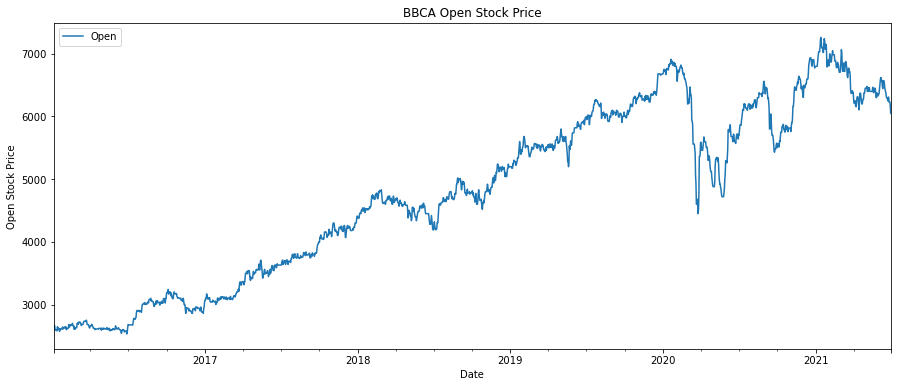

In [4]:
df[['Open']].plot(figsize=(15,6), title='BBCA Open Stock Price', ylabel='Open Stock Price');

### - Check Stationarity Data

In [5]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [6]:
# Cek stationary data open stock price
adfuller_test(df['Open'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.441361
p-value                    0.562294
# lags used                4.000000
# observations          1999.000000
critical value (1%)       -3.433625
critical value (5%)       -2.862987
critical value (10%)      -2.567540

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [7]:
# differencing
df['Open d1'] = diff(df['Open'], k_diff=1)     #lag 1

# Cek stationary data open stock price dengan differencing lag 1
adfuller_test(df['Open d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -20.994498
p-value                    0.000000
# lags used                3.000000
# observations          1999.000000
critical value (1%)       -3.433625
critical value (5%)       -2.862987
critical value (10%)      -2.567540

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data open stock price akan digunakan parameter differencing ARIMA d=1.

### - Seasonality Data

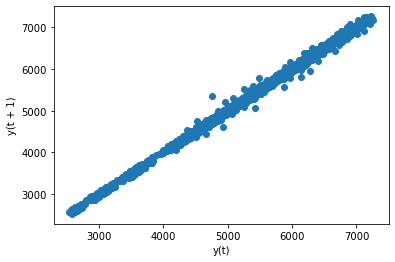

In [8]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Open']);

Pada plot lag, tidak terlihat adanya seasonality

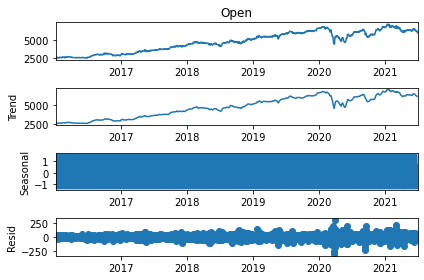

In [9]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Open'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA.

### - Autoregression (AR) Parameter

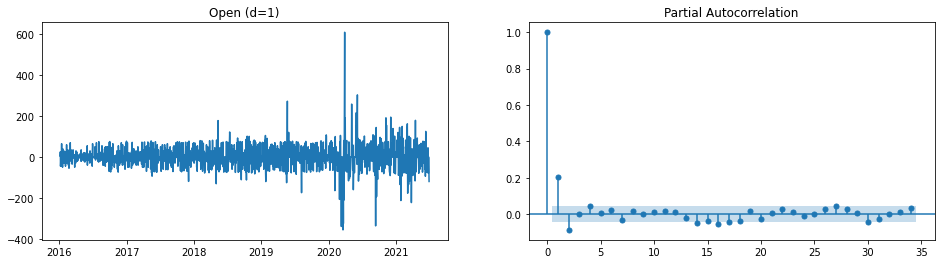

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Open'].diff().dropna())
ax1.set_title('Open (d=1)')
plot_pacf(df['Open'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

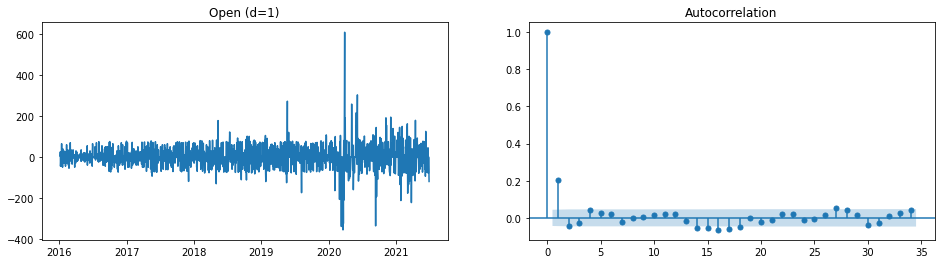

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Open'].diff().dropna())
ax1.set_title('Open (d=1)')
plot_acf(df['Open'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 2.

### - Split Data

In [12]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [13]:
ARIMA_open = ARIMA(train_data['Open'], order=(2,1,2)).fit()
ARIMA_open.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 1944
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10362.653
Date:                Sun, 12 Dec 2021   AIC                          20735.307
Time:                        09:51:40   BIC                          20763.167
Sample:                    01-04-2016   HQIC                         20745.551
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1549      0.320     -0.484      0.628      -0.782       0.472
ar.L2         -0.2187      0.077     -2.830      0.005      -0.370      -0.067
ma.L1          0.3773      0.323      1.170      0.242      -0.255       1.009
ma.L2          0.2172      0.135      1.610      0.107      -0.047       0.482
sigma2      2519.4967     39.622     63.588      0.000    2441.838    2597.155
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15846.73
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.40   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [14]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_open.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) Test Prediction')
prediction_test

2021-05-01    6444.204387
2021-05-02    6442.655775
2021-05-03    6444.163171
2021-05-04    6444.268321
2021-05-05    6443.922368
2021-05-06    6443.952967
2021-05-07    6444.023886
2021-05-08    6444.006207
2021-05-09    6443.993436
2021-05-10    6443.999281
2021-05-11    6444.001168
2021-05-12    6443.999598
2021-05-13    6443.999428
2021-05-14    6443.999798
2021-05-15    6443.999778
2021-05-16    6443.999700
2021-05-17    6443.999716
2021-05-18    6443.999731
2021-05-19    6443.999725
2021-05-20    6443.999723
2021-05-21    6443.999724
2021-05-22    6443.999725
2021-05-23    6443.999724
2021-05-24    6443.999724
2021-05-25    6443.999724
2021-05-26    6443.999724
2021-05-27    6443.999724
2021-05-28    6443.999724
2021-05-29    6443.999724
2021-05-30    6443.999724
2021-05-31    6443.999724
2021-06-01    6443.999724
2021-06-02    6443.999724
2021-06-03    6443.999724
2021-06-04    6443.999724
2021-06-05    6443.999724
2021-06-06    6443.999724
2021-06-07    6443.999724
2021-06-08  

### - Model Evaluation

In [15]:
# rmse
error_rmse = rmse(test_data['Open'], prediction_test)
print(f'ARIMA(2,1,2) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Open'], prediction_test)
print(f'ARIMA(2,1,2) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_open.aic
print(f'ARIMA(2,1,2) AIC: {aic_values:6.5}')

ARIMA(2,1,2) RMSE Error:  116.565036
ARIMA(2,1,2) MAE Error: 88.25527706
ARIMA(2,1,2) AIC: 2.0735e+04


In [16]:
# perbandingan rata-rata open stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Open stock price actual:", test_data['Open'].mean())
print("Rata-rata Open stock price predicted:", prediction_test.mean())

Rata-rata Open stock price actual: 6402.554575341842
Rata-rata Open stock price predicted: 6443.986285645521


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [17]:
ARIMA_open = ARIMA(df['Open'], order=(2,1,2)).fit()
ARIMA_open.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 2004
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10678.492
Date:                Sun, 12 Dec 2021   AIC                          21366.984
Time:                        09:51:41   BIC                          21394.996
Sample:                    01-04-2016   HQIC                         21377.268
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2135      0.322     -0.664      0.507      -0.844       0.417
ar.L2         -0.2142      0.077     -2.768      0.006      -0.366      -0.063
ma.L1          0.4359      0.324      1.344      0.179      -0.200       1.072
ma.L2          0.2259      0.134      1.680      0.093      -0.038       0.489
sigma2      2508.0291     39.113     64.122      0.000    2431.369    2584.690
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15681.90
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.15   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value

Predict open stock price for the next 6 months

In [18]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_open.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) Open Stock Price Forecast')
forecast

2021-06-30    6029.243804
2021-07-01    6035.833187
2021-07-02    6038.873084
2021-07-03    6036.812607
2021-07-04    6036.601214
                 ...     
2021-12-24    6036.973713
2021-12-25    6036.973713
2021-12-26    6036.973713
2021-12-27    6036.973713
2021-12-28    6036.973713
Freq: D, Name: ARIMA(2,1,2) Open Stock Price Forecast, Length: 182, dtype: float64

In [19]:
# save model
ARIMA_open.save('model_bca_open.pkl')
# load model
# ARIMA_open = ARIMAResults.load('model_bca_open.pkl')

## 4. High Stock Price Model

### - Plot

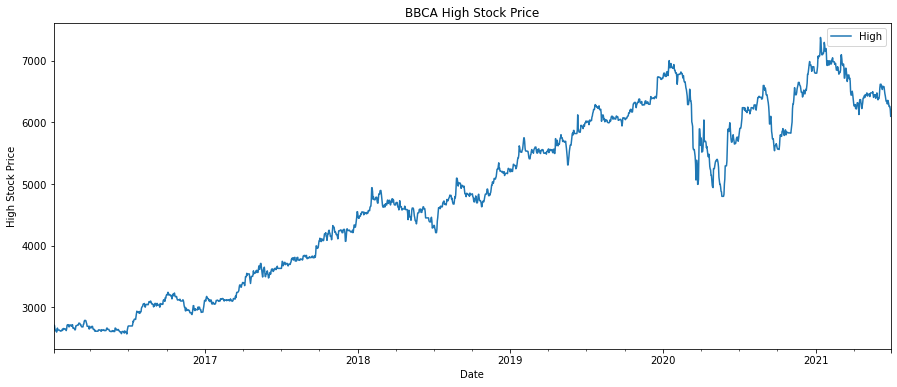

In [20]:
df[['High']].plot(figsize=(15,6), title='BBCA High Stock Price', ylabel='High Stock Price');

### - Check Stationary Data

In [21]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [22]:
# Cek stationary data high stock price
adfuller_test(df['High'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.333369
p-value                    0.613771
# lags used               19.000000
# observations          1984.000000
critical value (1%)       -3.433650
critical value (5%)       -2.862998
critical value (10%)      -2.567546

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


### - Differencing

In [23]:
# differencing
df['High d1'] = diff(df['High'], k_diff=1)     #lag 1

# Cek stationary data high stock price dengan differencing lag 1
adfuller_test(df['High d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.158304e+01
p-value                 2.911610e-21
# lags used             1.800000e+01
# observations          1.984000e+03
critical value (1%)    -3.433650e+00
critical value (5%)    -2.862998e+00
critical value (10%)   -2.567546e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data high stock price akan digunakan parameter differencing ARIMA d=1.

### - Seasonality Data

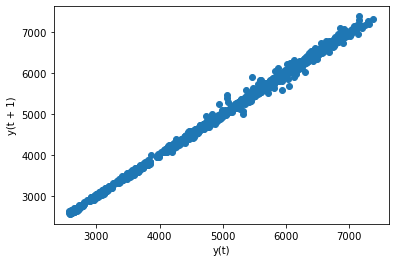

In [24]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['High']);

Pada plot lag, tidak terlihat adanya seasonality

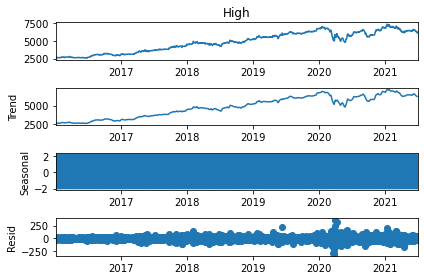

In [25]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['High'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data high stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

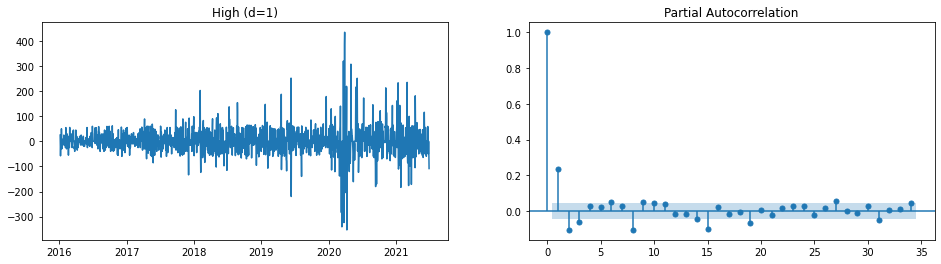

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['High'].diff().dropna())
ax1.set_title('High (d=1)')
plot_pacf(df['High'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 3

### - Moving Average (MA) Parameter

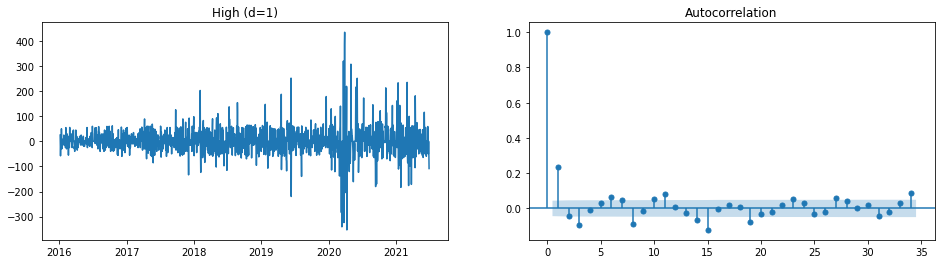

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['High'].diff().dropna())
ax1.set_title('High (d=1)')
plot_acf(df['High'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 3

### - Split Data

In [28]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [29]:
ARIMA_high = ARIMA(train_data['High'], order=(3,1,3)).fit()
ARIMA_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1944
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -10200.672
Date:                Sun, 12 Dec 2021   AIC                          20415.344
Time:                        09:51:46   BIC                          20454.348
Sample:                    01-04-2016   HQIC                         20429.687
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9111      0.082     11.178      0.000       0.751       1.071
ar.L2         -1.0013      0.071    -14.134      0.000      -1.140      -0.862
ar.L3          0.0444      0.076      0.584      0.559      -0.105       0.194
ma.L1         -0.6652      0.082     -8.074      0.000      -0.827      -0.504
ma.L2          0.7663      0.068     11.269      0.000       0.633       0.900
ma.L3          0.1634      0.071      2.305      0.021       0.024       0.302
sigma2      2141.0965     27.199     78.719      0.000    2087.787    2194.406
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14495.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.81   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [30]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_high.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,3) Test Prediction')
prediction_test

2021-05-01    6445.448520
2021-05-02    6452.943507
2021-05-03    6463.614147
2021-05-04    6465.628718
2021-05-05    6457.112227
2021-05-06    6447.809843
2021-05-07    6447.952021
2021-05-08    6457.018011
2021-05-09    6464.722189
2021-05-10    6462.669504
2021-05-11    6453.487647
2021-05-12    6447.519965
2021-05-13    6451.185874
2021-05-14    6460.093540
2021-05-15    6464.273181
2021-05-16    6459.324453
2021-05-17    6451.026291
2021-05-18    6448.607051
2021-05-19    6454.492330
2021-05-20    6461.908088
2021-05-21    6462.663797
2021-05-22    6456.188102
2021-05-23    6449.860981
2021-05-24    6450.614405
2021-05-25    6457.348715
2021-05-26    6462.448669
2021-05-27    6460.385286
2021-05-28    6453.697798
2021-05-29    6449.897693
2021-05-30    6453.040258
2021-05-31    6459.411457
2021-06-01    6461.900524
2021-06-02    6457.928158
2021-06-03    6452.099682
2021-06-04    6450.877745
2021-06-05    6455.424250
2021-06-06    6460.531099
2021-06-07    6460.576966
2021-06-08  

### - Model Evaluation

In [31]:
# rmse
error_rmse = rmse(test_data['High'], prediction_test)
print(f'ARIMA(3,1,3) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['High'], prediction_test)
print(f'ARIMA(3,1,3) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_high.aic
print(f'ARIMA(3,1,3) AIC: {aic_values:6.5}')

ARIMA(3,1,3) RMSE Error: 104.2221789
ARIMA(3,1,3) MAE Error: 75.58934765
ARIMA(3,1,3) AIC: 2.0415e+04


In [32]:
# perbandingan rata-rata high stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata High stock price actual:", test_data['High'].mean())
print("Rata-rata High stock price predicted:", prediction_test.mean())

Rata-rata High stock price actual: 6438.55806703186
Rata-rata High stock price predicted: 6456.048738644205


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [33]:
ARIMA_high = ARIMA(df['High'], order=(3,1,3)).fit()
ARIMA_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 2004
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -10506.695
Date:                Sun, 12 Dec 2021   AIC                          21027.390
Time:                        09:51:48   BIC                          21066.607
Sample:                    01-04-2016   HQIC                         21041.789
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9227      0.082     11.293      0.000       0.763       1.083
ar.L2         -1.0103      0.071    -14.274      0.000      -1.149      -0.872
ar.L3          0.0564      0.076      0.741      0.459      -0.093       0.206
ma.L1         -0.6770      0.083     -8.183      0.000      -0.839      -0.515
ma.L2          0.7746      0.068     11.377      0.000       0.641       0.908
ma.L3          0.1523      0.071      2.137      0.033       0.013       0.292
sigma2      2122.3502     26.688     79.524      0.000    2070.043    2174.658
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14651.77
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.29   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value

Predict high stock price for the next 6 months

In [34]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_high.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,3) High Stock Price Forecast')
forecast

2021-06-30    6073.496867
2021-07-01    6073.665725
2021-07-02    6079.953729
2021-07-03    6084.092696
2021-07-04    6081.568704
                 ...     
2021-12-24    6078.236437
2021-12-25    6078.321538
2021-12-26    6078.226254
2021-12-27    6078.062278
2021-12-28    6078.012035
Freq: D, Name: ARIMA(3,1,3) High Stock Price Forecast, Length: 182, dtype: float64

In [35]:
# save model
ARIMA_high.save('model_bca_high.pkl')

# 5. Low Stock Price Model

### - Plot

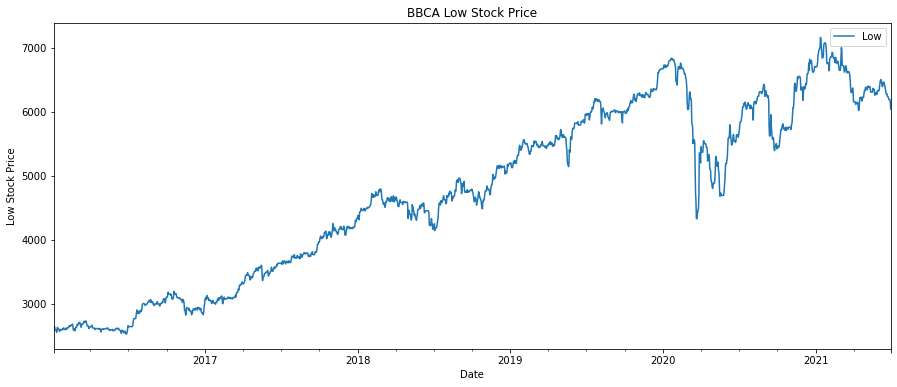

In [36]:
df[['Low']].plot(figsize=(15,6), title='BBCA Low Stock Price', ylabel='Low Stock Price');

### - Check Stationary Data

In [37]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [38]:
# Cek stationary data low stock price
adfuller_test(df['Low'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.356094
p-value                    0.603135
# lags used               15.000000
# observations          1988.000000
critical value (1%)       -3.433644
critical value (5%)       -2.862995
critical value (10%)      -2.567545

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


### - Differencing

In [39]:
# differencing
df['Low d1'] = diff(df['Low'], k_diff=1)     #lag 1

# Cek stationary data low stock price dengan differencing lag 1
adfuller_test(df['Low d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.258826e+01
p-value                 1.845316e-23
# lags used             1.400000e+01
# observations          1.988000e+03
critical value (1%)    -3.433644e+00
critical value (5%)    -2.862995e+00
critical value (10%)   -2.567545e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data low stock price akan digunakan parameter differencing ARIMA d=1

### - Seasonality Data

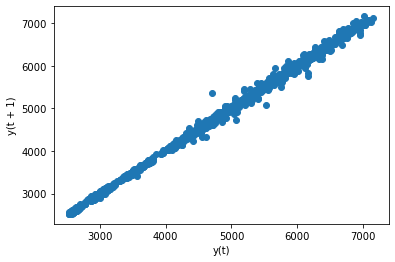

In [40]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Low']);

Pada plot lag, tidak terlihat adanya seasonality

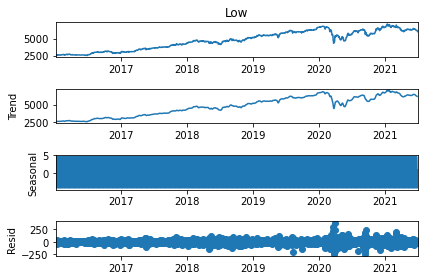

In [41]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Low'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data low stock price, sehingga akan digunakan model ARIMA.

### - Autoregression (AR) Parameter

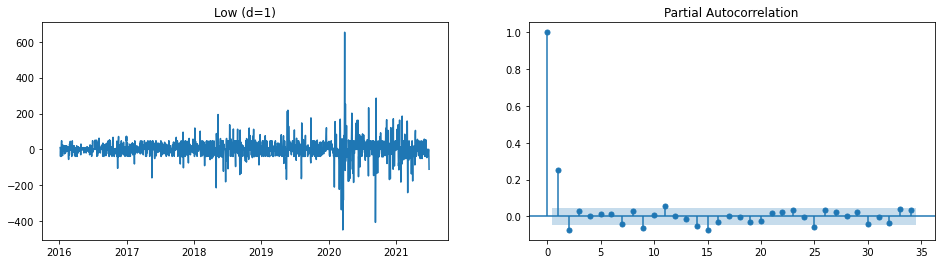

In [42]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Low'].diff().dropna())
ax1.set_title('Low (d=1)')
plot_pacf(df['Low'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

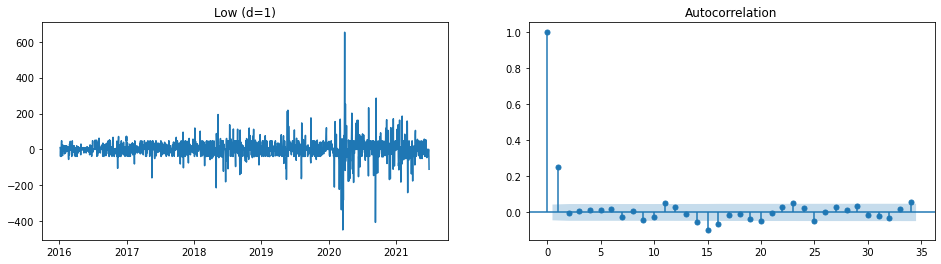

In [43]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Low'].diff().dropna())
ax1.set_title('Low (d=1)')
plot_acf(df['Low'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [44]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [45]:
ARIMA_low = ARIMA(train_data['Low'], order=(2,1,1)).fit()
ARIMA_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 1944
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10277.842
Date:                Sun, 12 Dec 2021   AIC                          20563.684
Time:                        09:51:51   BIC                          20585.972
Sample:                    01-04-2016   HQIC                         20571.880
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0400      0.137     -0.292      0.770      -0.308       0.229
ar.L2          0.0071      0.041      0.175      0.861      -0.073       0.087
ma.L1          0.3132      0.136      2.306      0.021       0.047       0.579
sigma2      2304.6685     22.633    101.829      0.000    2260.309    2349.028
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             46595.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.90   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [46]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_low.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Test Prediction')
prediction_test

2021-05-01    6381.529258
2021-05-02    6381.610158
2021-05-03    6381.617784
2021-05-04    6381.618054
2021-05-05    6381.618097
2021-05-06    6381.618097
2021-05-07    6381.618098
2021-05-08    6381.618098
2021-05-09    6381.618098
2021-05-10    6381.618098
2021-05-11    6381.618098
2021-05-12    6381.618098
2021-05-13    6381.618098
2021-05-14    6381.618098
2021-05-15    6381.618098
2021-05-16    6381.618098
2021-05-17    6381.618098
2021-05-18    6381.618098
2021-05-19    6381.618098
2021-05-20    6381.618098
2021-05-21    6381.618098
2021-05-22    6381.618098
2021-05-23    6381.618098
2021-05-24    6381.618098
2021-05-25    6381.618098
2021-05-26    6381.618098
2021-05-27    6381.618098
2021-05-28    6381.618098
2021-05-29    6381.618098
2021-05-30    6381.618098
2021-05-31    6381.618098
2021-06-01    6381.618098
2021-06-02    6381.618098
2021-06-03    6381.618098
2021-06-04    6381.618098
2021-06-05    6381.618098
2021-06-06    6381.618098
2021-06-07    6381.618098
2021-06-08  

### - Model Evaluation

In [47]:
# rmse
error_rmse = rmse(test_data['Low'], prediction_test)
print(f'ARIMA(2,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Low'], prediction_test)
print(f'ARIMA(2,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_low.aic
print(f'ARIMA(2,1,1) AIC: {aic_values:6.5}')

ARIMA(2,1,1) RMSE Error: 100.2640672
ARIMA(2,1,1) MAE Error: 76.96224856
ARIMA(2,1,1) AIC: 2.0564e+04


In [48]:
# perbandingan rata-rata low stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Low stock price actual:", test_data['Low'].mean())
print("Rata-rata Low stock price predicted:", prediction_test.mean())

Rata-rata Low stock price actual: 6334.281263092504
Rata-rata Low stock price predicted: 6381.61647874573


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [49]:
ARIMA_low = ARIMA(df['Low'], order=(2,1,1)).fit()
ARIMA_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 2004
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10575.952
Date:                Sun, 12 Dec 2021   AIC                          21159.905
Time:                        09:51:51   BIC                          21182.315
Sample:                    01-04-2016   HQIC                         21168.133
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0381      0.133     -0.287      0.774      -0.298       0.222
ar.L2          0.0069      0.040      0.175      0.861      -0.071       0.085
ma.L1          0.3137      0.131      2.388      0.017       0.056       0.571
sigma2      2260.6531     21.750    103.939      0.000    2218.024    2303.282
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             48759.44
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.08   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value

Predict low stock price for the next 6 months

In [50]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_low.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Low Stock Price Forecast')
forecast

2021-06-30    6012.561697
2021-07-01    6012.837017
2021-07-02    6012.635837
2021-07-03    6012.645418
2021-07-04    6012.643654
                 ...     
2021-12-24    6012.643772
2021-12-25    6012.643772
2021-12-26    6012.643772
2021-12-27    6012.643772
2021-12-28    6012.643772
Freq: D, Name: ARIMA(2,1,1) Low Stock Price Forecast, Length: 182, dtype: float64

In [51]:
# save model
ARIMA_low.save('model_bca_low.pkl')

# 6. Stock Volume Model

### - Plot

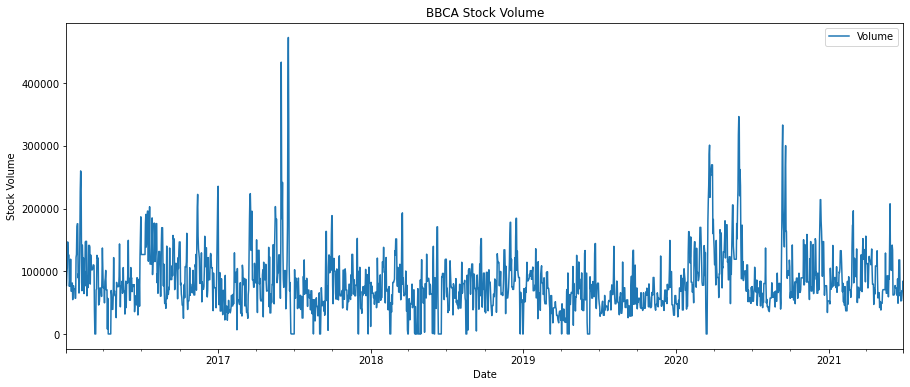

In [52]:
df[['Volume']].plot(figsize=(15,6), title='BBCA Stock Volume', ylabel='Stock Volume');

### - Check Stationarity Data

In [53]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [54]:
# Cek stationary data stock volume
adfuller_test(df['Volume'])

Augmented Dickey-Fuller Test:
ADF test statistic     -7.156745e+00
p-value                 3.040798e-10
# lags used             1.300000e+01
# observations          1.990000e+03
critical value (1%)    -3.433640e+00
critical value (5%)    -2.862993e+00
critical value (10%)   -2.567544e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data stock volume sudah stationer, maka tidak perlu dilakukan differencing. Dari informasi ini, untuk data volume stock akan digunakan parameter differencing ARIMA d=0.

### - Seasonality Data

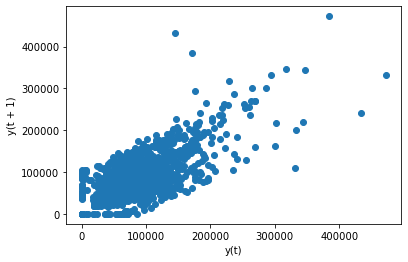

In [55]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Volume']);

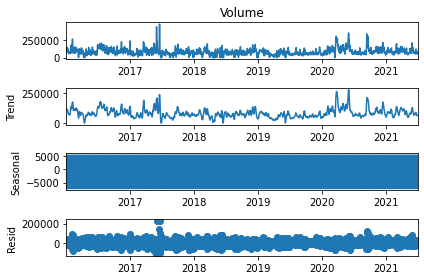

In [56]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Volume'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

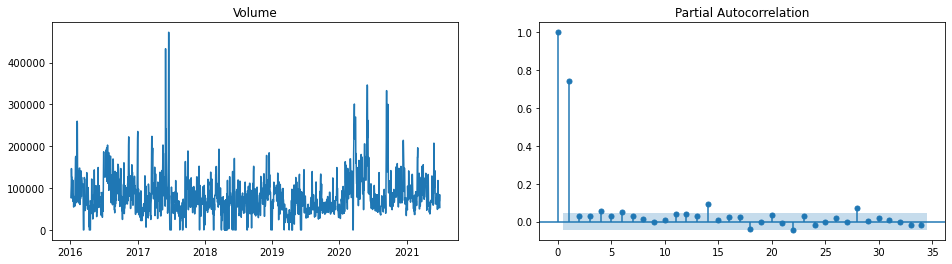

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Volume'].dropna())
ax1.set_title('Volume')
plot_pacf(df['Volume'].dropna(), ax=ax2);

### - Moving Avarage (MA) Parameter

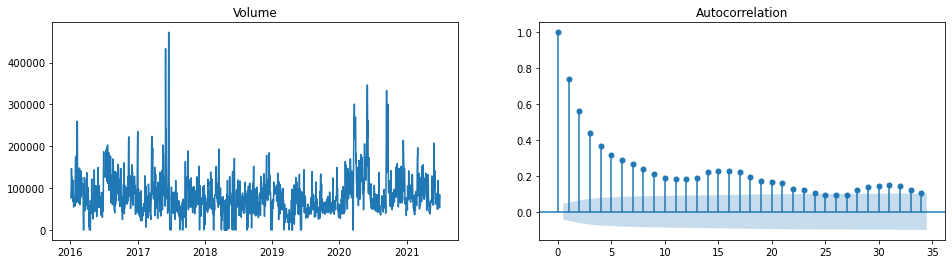

In [58]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Volume'].dropna())
ax1.set_title('Volume')
plot_acf(df['Volume'].dropna(), ax=ax2);

Jika PACF dari deret yang berbeda menampilkan cutoff yang tajam atau autokorelasi lag-1 positif, sedangkan ACF meluruh lebih lambat, maka pertimbangkan untuk menambahkan suku AR ke model. Artinya pola autokorelasi dapat dijelaskan lebih mudah dengan menambahkan suku AR daripada menambahkan suku MA. Jeda di mana PACF terputus menunjukkan jumlah istilah AR. Karena AR menunjukkan autokorelasi lag-1 positif, maka akan digunakan p = 1, q = 0.

### - Split Data

In [59]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [60]:
ARIMA_volume = ARIMA(train_data['Volume'], order=(1,0,0)).fit()
ARIMA_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 1944
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -22936.951
Date:                Sun, 12 Dec 2021   AIC                          45879.902
Time:                        09:51:53   BIC                          45896.620
Sample:                    01-04-2016   HQIC                         45886.049
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.259e+04   3099.399     26.646      0.000    7.65e+04    8.87e+04
ar.L1          0.7434      0.009     81.408      0.000       0.726       0.761
sigma2      1.037e+09      0.156   6.64e+09      0.000    1.04e+09    1.04e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):              3712.90
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+24. Standard errors may be unstable.
"""

### - Predictions in Test Data

In [61]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_volume.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Test Prediction')
prediction_test

2021-05-01    70129.170136
2021-05-02    73325.358697
2021-05-03    75701.543169
2021-05-04    77468.101223
2021-05-05    78781.436696
2021-05-06    79757.826949
2021-05-07    80483.717589
2021-05-08    81023.376008
2021-05-09    81424.581359
2021-05-10    81722.854727
2021-05-11    81944.604017
2021-05-12    82109.462007
2021-05-13    82232.024549
2021-05-14    82323.142830
2021-05-15    82390.884092
2021-05-16    82441.245868
2021-05-17    82478.686986
2021-05-18    82506.522328
2021-05-19    82527.216322
2021-05-20    82542.601130
2021-05-21    82554.038861
2021-05-22    82562.542163
2021-05-23    82568.863884
2021-05-24    82573.563725
2021-05-25    82577.057789
2021-05-26    82579.655427
2021-05-27    82581.586623
2021-05-28    82583.022358
2021-05-29    82584.089745
2021-05-30    82584.883287
2021-05-31    82585.473240
2021-06-01    82585.911836
2021-06-02    82586.237908
2021-06-03    82586.480324
2021-06-04    82586.660546
2021-06-05    82586.794531
2021-06-06    82586.894141
2

### - Model Evaluation

In [62]:
# rmse
error_rmse = rmse(test_data['Volume'], prediction_test)
print(f'ARIMA(1,0,0) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Volume'], prediction_test)
print(f'ARIMA(1,0,0) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_volume.aic
print(f'ARIMA(1,0,0) AIC: {aic_values:6.5}')

ARIMA(1,0,0) RMSE Error:  29329.9893
ARIMA(1,0,0) MAE Error: 22425.66484
ARIMA(1,0,0) AIC: 4.588e+04


In [63]:
# perbandingan rata-rata stock volume 2 bulan kedepan antara predicted dan actual
print("Rata-rata stock Volume actual:", test_data['Volume'].mean())
print("Rata-rata stock Volume predicted:", prediction_test.mean())

Rata-rata stock Volume actual: 78670.27030995175
Rata-rata stock Volume predicted: 81777.87469481298


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [64]:
ARIMA_volume = ARIMA(df['Volume'], order=(1,0,0)).fit()
ARIMA_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 2004
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -23632.878
Date:                Sun, 12 Dec 2021   AIC                          47271.756
Time:                        09:51:54   BIC                          47288.565
Sample:                    01-04-2016   HQIC                         47277.927
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.247e+04   3016.703     27.338      0.000    7.66e+04    8.84e+04
ar.L1          0.7415      0.009     82.399      0.000       0.724       0.759
sigma2      1.025e+09      0.151   6.77e+09      0.000    1.02e+09    1.02e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):              3837.19
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.94e+24. Standard errors may be unstable.
"""

### - Forecasting The Future Value
Predict stock volume price for the next 6 months

In [65]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_volume.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Stock Volume Forecast')
forecast

2021-06-30    61139.724784
2021-07-01    66653.382679
2021-07-02    70741.810407
2021-07-03    73773.416938
2021-07-04    76021.380892
                  ...     
2021-12-24    82469.909960
2021-12-25    82469.909960
2021-12-26    82469.909960
2021-12-27    82469.909960
2021-12-28    82469.909960
Freq: D, Name: ARIMA(1,0,0) Stock Volume Forecast, Length: 182, dtype: float64

In [66]:
# save model
ARIMA_volume.save('model_bca_volume.pkl')

# 7. Adj. Close Stock Price Model

### - Plot

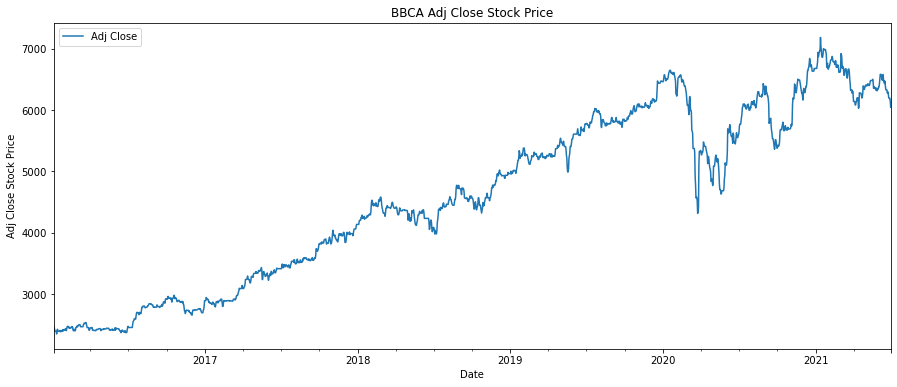

In [67]:
df[['Adj Close']].plot(figsize=(15,6), title='BBCA Adj Close Stock Price', ylabel='Adj Close Stock Price');

### - Check Stationarity Data

In [68]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [69]:
# Cek stationary data adj close stock price
adfuller_test(df['Adj Close'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.240053
p-value                    0.656133
# lags used               22.000000
# observations          1981.000000
critical value (1%)       -3.433655
critical value (5%)       -2.863000
critical value (10%)      -2.567547

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [70]:
# differencing
df['Adj Close d1'] = diff(df['Adj Close'], k_diff=1)     #lag 1

# Cek stationary data adj close stock price dengan differencing lag 1
adfuller_test(df['Adj Close d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.047858e+01
p-value                 1.230542e-18
# lags used             2.100000e+01
# observations          1.981000e+03
critical value (1%)    -3.433655e+00
critical value (5%)    -2.863000e+00
critical value (10%)   -2.567547e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data adj close stock price akan digunakan parameter differencing ARIMA d=1

### - Seasonality Data

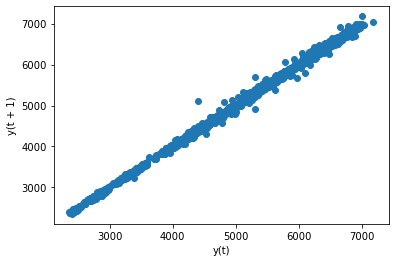

In [71]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Adj Close']);

Pada plot lag, tidak terlihat adanya seasonality

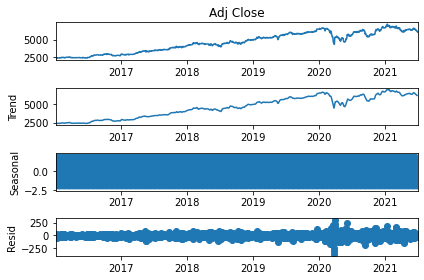

In [72]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Adj Close'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

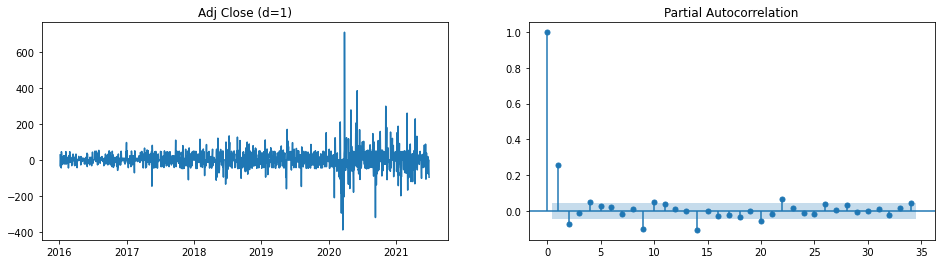

In [73]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Adj Close'].diff().dropna())
ax1.set_title('Adj Close (d=1)')
plot_pacf(df['Adj Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2 

### - Moving Average (MA) Parameter

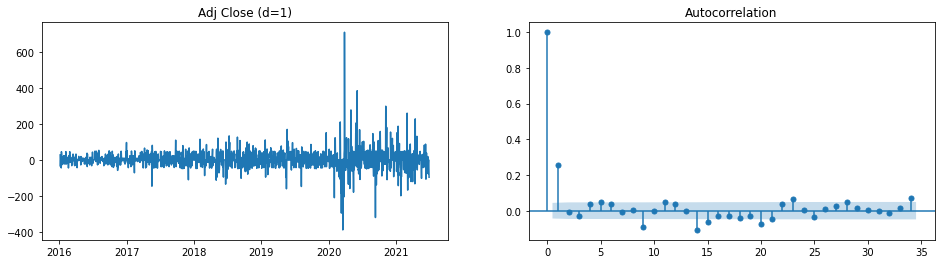

In [74]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Adj Close'].diff().dropna())
ax1.set_title('Adj Close (d=1)')
plot_acf(df['Adj Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [75]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [76]:
ARIMA_adjclose = ARIMA(train_data['Adj Close'], order=(2,1,1)).fit()
ARIMA_adjclose.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1944
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10169.442
Date:                Sun, 12 Dec 2021   AIC                          20346.885
Time:                        09:51:56   BIC                          20369.173
Sample:                    01-04-2016   HQIC                         20355.080
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3396      0.173      1.961      0.050       0.000       0.679
ar.L2         -0.0911      0.047     -1.930      0.054      -0.184       0.001
ma.L1         -0.0650      0.172     -0.378      0.705      -0.402       0.272
sigma2      2060.9785     19.278    106.911      0.000    2023.195    2098.762
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            114802.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               9.67   Skew:                             1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [77]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_adjclose.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Test Prediction')
prediction_test

2021-05-01    6410.091517
2021-05-02    6409.661993
2021-05-03    6409.052453
2021-05-04    6408.884571
2021-05-05    6408.883068
2021-05-06    6408.897846
2021-05-07    6408.903002
2021-05-08    6408.903407
2021-05-09    6408.903075
2021-05-10    6408.902925
2021-05-11    6408.902905
2021-05-12    6408.902911
2021-05-13    6408.902915
2021-05-14    6408.902916
2021-05-15    6408.902916
2021-05-16    6408.902916
2021-05-17    6408.902916
2021-05-18    6408.902916
2021-05-19    6408.902916
2021-05-20    6408.902916
2021-05-21    6408.902916
2021-05-22    6408.902916
2021-05-23    6408.902916
2021-05-24    6408.902916
2021-05-25    6408.902916
2021-05-26    6408.902916
2021-05-27    6408.902916
2021-05-28    6408.902916
2021-05-29    6408.902916
2021-05-30    6408.902916
2021-05-31    6408.902916
2021-06-01    6408.902916
2021-06-02    6408.902916
2021-06-03    6408.902916
2021-06-04    6408.902916
2021-06-05    6408.902916
2021-06-06    6408.902916
2021-06-07    6408.902916
2021-06-08  

### - Model Evaluation

In [78]:
# rmse
error_rmse = rmse(test_data['Adj Close'], prediction_test)
print(f'ARIMA(2,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Adj Close'], prediction_test)
print(f'ARIMA(2,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_adjclose.aic
print(f'ARIMA(2,1,1) AIC: {aic_values:6.5}')

ARIMA(2,1,1) RMSE Error: 111.4773159
ARIMA(2,1,1) MAE Error: 85.10929613
ARIMA(2,1,1) AIC: 2.0347e+04


In [79]:
# perbandingan rata-rata adjusted close stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Adjusted Close stock price actual:", test_data['Adj Close'].mean())
print("Rata-rata Adjusted Close stock price predicted:", prediction_test.mean())

Rata-rata Adjusted Close stock price actual: 6392.562888736354
Rata-rata Adjusted Close stock price predicted: 6408.937160716384


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [80]:
ARIMA_adjclose = ARIMA(df['Adj Close'], order=(2,1,1)).fit()
ARIMA_adjclose.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2004
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10474.767
Date:                Sun, 12 Dec 2021   AIC                          20957.534
Time:                        09:51:56   BIC                          20979.944
Sample:                    01-04-2016   HQIC                         20965.762
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3275      0.170      1.930      0.054      -0.005       0.660
ar.L2         -0.0888      0.046     -1.913      0.056      -0.180       0.002
ma.L1         -0.0534      0.168     -0.317      0.751      -0.383       0.277
sigma2      2043.0967     18.923    107.972      0.000    2006.009    2080.184
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            115662.10
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               9.23   Skew:                             1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value

Predict Adj Close stock price for the next 6 months

In [81]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_adjclose.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Adj Close Stock Price Forecast')
forecast

2021-06-30    6022.188444
2021-07-01    6023.276658
2021-07-02    6025.659411
2021-07-03    6026.343196
2021-07-04    6026.355506
                 ...     
2021-12-24    6026.279581
2021-12-25    6026.279581
2021-12-26    6026.279581
2021-12-27    6026.279581
2021-12-28    6026.279581
Freq: D, Name: ARIMA(2,1,1) Adj Close Stock Price Forecast, Length: 182, dtype: float64

In [82]:
# save model
ARIMA_adjclose.save('model_bca_adjclose.pkl')

# 8. Close Stock Price Model

### - Plot

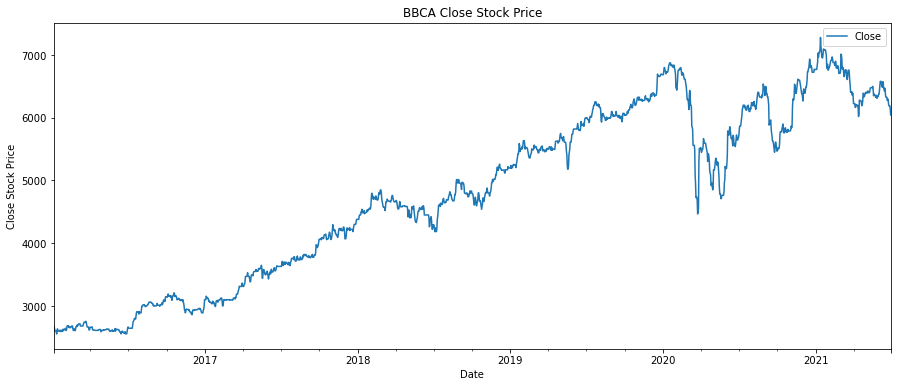

In [83]:
df[['Close']].plot(figsize=(15,6), title='BBCA Close Stock Price', ylabel='Close Stock Price');

### - Check Stationarity Data

In [84]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [85]:
# Cek stationary data close stock price
adfuller_test(df['Close'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.359553
p-value                    0.601506
# lags used               22.000000
# observations          1981.000000
critical value (1%)       -3.433655
critical value (5%)       -2.863000
critical value (10%)      -2.567547

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [86]:
# differencing
df['Close d1'] = diff(df['Close'], k_diff=1)     #lag 1

# Cek stationary data close stock price dengan differencing lag 1
adfuller_test(df['Close d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.040222e+01
p-value                 1.896447e-18
# lags used             2.100000e+01
# observations          1.981000e+03
critical value (1%)    -3.433655e+00
critical value (5%)    -2.863000e+00
critical value (10%)   -2.567547e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data close stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

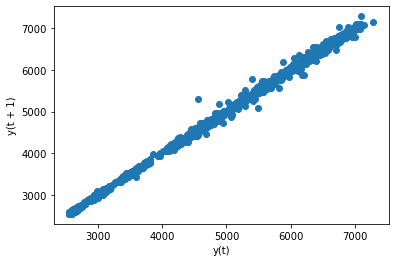

In [87]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Close']);

Pada plot lag, tidak terlihat adanya seasonality

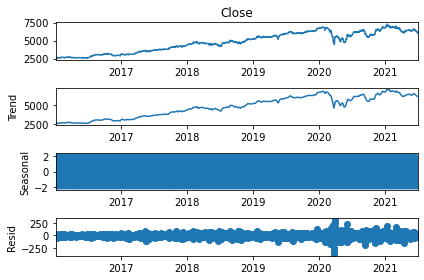

In [88]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Close'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA

### - Autoregression (AR) Parameter

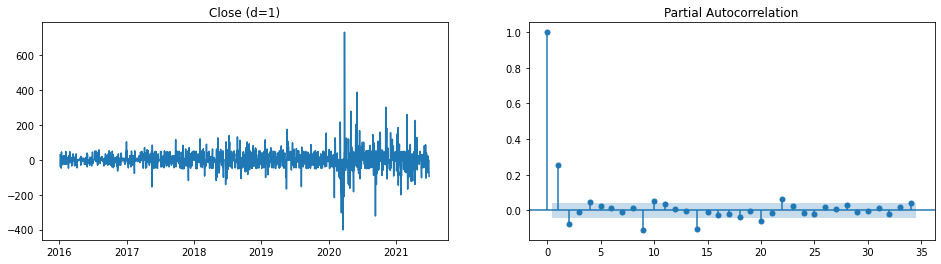

In [89]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Close'].diff().dropna())
ax1.set_title('Close (d=1)')
plot_pacf(df['Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2 

### - Moving Average (MA) Parameter

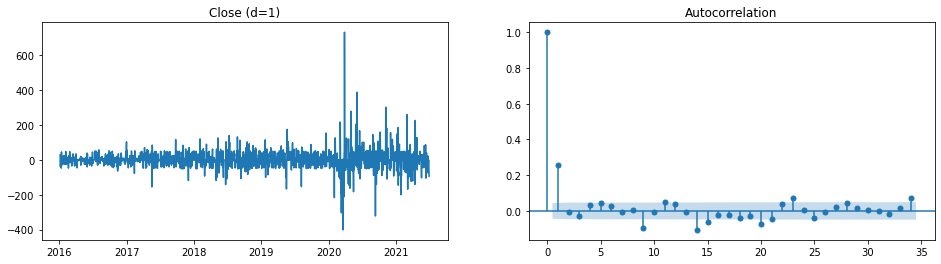

In [90]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Close'].diff().dropna())
ax1.set_title('Close (d=1)')
plot_acf(df['Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [91]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [92]:
ARIMA_close = ARIMA(train_data['Close'], order=(2,1,1)).fit()
ARIMA_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1944
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10230.587
Date:                Sun, 12 Dec 2021   AIC                          20469.174
Time:                        09:51:58   BIC                          20491.462
Sample:                    01-04-2016   HQIC                         20477.370
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3320      0.173      1.924      0.054      -0.006       0.670
ar.L2         -0.0891      0.048     -1.871      0.061      -0.182       0.004
ma.L1         -0.0544      0.171     -0.318      0.750      -0.390       0.281
sigma2      2194.7792     20.725    105.898      0.000    2154.158    2235.400
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            114256.99
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               8.94   Skew:                             1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [93]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_close.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Test Prediction')
prediction_test

2021-05-01    6409.361482
2021-05-02    6408.863625
2021-05-03    6408.309793
2021-05-04    6408.170269
2021-05-05    6408.173284
2021-05-06    6408.186715
2021-05-07    6408.190905
2021-05-08    6408.191100
2021-05-09    6408.190791
2021-05-10    6408.190671
2021-05-11    6408.190659
2021-05-12    6408.190666
2021-05-13    6408.190669
2021-05-14    6408.190669
2021-05-15    6408.190669
2021-05-16    6408.190669
2021-05-17    6408.190669
2021-05-18    6408.190669
2021-05-19    6408.190669
2021-05-20    6408.190669
2021-05-21    6408.190669
2021-05-22    6408.190669
2021-05-23    6408.190669
2021-05-24    6408.190669
2021-05-25    6408.190669
2021-05-26    6408.190669
2021-05-27    6408.190669
2021-05-28    6408.190669
2021-05-29    6408.190669
2021-05-30    6408.190669
2021-05-31    6408.190669
2021-06-01    6408.190669
2021-06-02    6408.190669
2021-06-03    6408.190669
2021-06-04    6408.190669
2021-06-05    6408.190669
2021-06-06    6408.190669
2021-06-07    6408.190669
2021-06-08  

### - Model Evaluation

In [94]:
# rmse
error_rmse = rmse(test_data['Close'], prediction_test)
print(f'ARIMA(2,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Close'], prediction_test)
print(f'ARIMA(2,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_close.aic
print(f'ARIMA(2,1,1) AIC: {aic_values:6.5}')

ARIMA(2,1,1) RMSE Error: 111.5207026
ARIMA(2,1,1) MAE Error: 85.10031805
ARIMA(2,1,1) AIC: 2.0469e+04


In [95]:
# perbandingan rata-rata close stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Close stock price actual:", test_data['Close'].mean())
print("Rata-rata Close stock price predicted:", prediction_test.mean())

Rata-rata Close stock price actual: 6392.362869881452
Rata-rata Close stock price predicted: 6408.222701367337


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [96]:
ARIMA_close = ARIMA(df['Close'], order=(2,1,1)).fit()
ARIMA_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2004
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10536.748
Date:                Sun, 12 Dec 2021   AIC                          21081.495
Time:                        09:51:59   BIC                          21103.905
Sample:                    01-04-2016   HQIC                         21089.723
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3205      0.169      1.892      0.058      -0.011       0.652
ar.L2         -0.0868      0.047     -1.854      0.064      -0.179       0.005
ma.L1         -0.0435      0.168     -0.259      0.795      -0.372       0.285
sigma2      2173.4466     20.306    107.036      0.000    2133.648    2213.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            115602.63
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               8.53   Skew:                             1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value

Predict close stock price for the next 6 months

In [97]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_close.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Open Stock Price Forecast')
forecast

2021-06-30    6022.750763
2021-07-01    6023.790453
2021-07-02    6026.055726
2021-07-03    6026.691418
2021-07-04    6026.698434
                 ...     
2021-12-24    6026.628541
2021-12-25    6026.628541
2021-12-26    6026.628541
2021-12-27    6026.628541
2021-12-28    6026.628541
Freq: D, Name: ARIMA(2,1,1) Open Stock Price Forecast, Length: 182, dtype: float64

In [98]:
# save model
ARIMA_close.save('model_bca_close.pkl')